In [2]:
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import mlab

import os
import json

# from uncertainties import unumpy as unp
# from uncertainties import ufloat, umath

from options import *
from constants import *

# nom_vals = unp.nominal_values
# std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

In [3]:
def load(dataset: str):
    raw_data = np.fromfile(dataset, np.complex64)
    with open(dataset.replace("raw.dat", "params.json"), "r") as file:
        params = json.load(file)
    
    spectrum, frequencies = mlab.psd(raw_data, NFFT=NFFT, Fs=SAMPLE_RATE)
    frequencies += params['frequency']

    return raw_data, (spectrum, frequencies), params

In [4]:
datasets = []

# _, (galaxy_spectrum, frequencies), _ = load("../data/galactic_test1_2025_02_28_11_13_50_raw.dat")
# _, (galaxy_spectrum2, frequencies), _ = load("../data/galactic_test2_2025_02_28_13_46_12_raw.dat")
# _, (bm_noise1_spectrum, _), _ = load("../data/batiment_test1_2025_02_28_11_33_58_raw.dat")
# _, (bm_noise2_spectrum, _), _ = load("../data/batiment_test2_2025_02_28_11_44_57_raw.dat")
_, (bc_noise3_spectrum, _), _ = load("../data/bc_test3_2025_02_28_13_31_31_raw.dat")
_, (l30_spectrum, frequencies), _ = load("../data/h_30_2025_03_07_09_31_26_raw.dat")

In [5]:
def calculate_average(spectrum: np.ndarray) -> float:
    idx = np.r_[200:500,550:850]
    return np.mean(spectrum[idx])

In [6]:
def normalise_data(signal: np.ndarray, noise: np.ndarray) -> np.ndarray:
    return signal / noise

In [7]:
def clean_up(signal: np.ndarray, w: int = 10) -> np.ndarray:
    cleaned = np.convolve(signal, np.ones(w), 'same') / w
    return cleaned

In [8]:
def calculate_relative_speed(measured_frequency: float) -> float:
    return sc.constants.c * (H21 - measured_frequency) / measured_frequency

## Example de cleanup signal

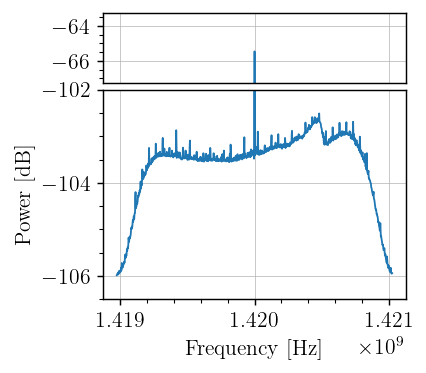

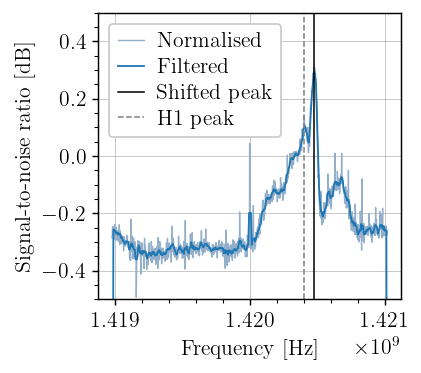

In [31]:
with mpl.rc_context():
    mpl.rcParams['savefig.bbox'] = 'standard'
    mpl.rcParams["figure.figsize"] = (8*INCH_PER_CM, 7*INCH_PER_CM)
    mpl.rcParams["figure.subplot.left"]   = 0.25
    mpl.rcParams['figure.subplot.right']  = 0.99
    mpl.rcParams['figure.subplot.top']    = 0.97
    mpl.rcParams['figure.subplot.bottom'] = 0.17
    
    vertical_lw = 0.85
    
    # ==== Unprocessed signal ====
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, height_ratios=[1,3])
    fig.subplots_adjust(hspace=0.05)  # adjust space between Axes

    ax1.plot(frequencies, to_dB(l30_spectrum))
    ax2.plot(frequencies, to_dB(l30_spectrum))

    ax1.set_ylim(-67.25, -63.25)
    # ax1.set_ylim(-102, -40)
    ax2.set_ylim(-106.5,-102)
    # ax1.set_xticks([])
    ax1.tick_params(axis='x', which='both',
                bottom=False)

    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Power [dB]")
    plt.savefig("../figures/raw_signal.pdf")
    plt.show()

    # ==== Processed signal (noise removal + moving average)
    plt.figure()
    normalised_signal = normalise_data(l30_spectrum,bc_noise3_spectrum)
    cleaned_signal = clean_up(normalised_signal)
    
    plt.plot(frequencies, to_dB(normalised_signal), c='#93afca', lw=0.75,
             label="Normalised")
    plt.plot(frequencies, to_dB(cleaned_signal), c="C0",
             label="Filtered")
    hydrogen_peak_idx = sc.signal.find_peaks(cleaned_signal, width=20)[0][2]
    plt.axvline(frequencies[hydrogen_peak_idx], lw=vertical_lw, ls='-', c='k',
                label="Shifted peak")
    plt.axvline(H21, lw=vertical_lw, ls="--",
                label="H1 peak")
    
    plt.ylim(-0.5,0.5)

    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Signal-to-noise ratio [dB]")
    plt.legend(loc="upper left")
    plt.savefig("../figures/clean_signal.pdf")
    plt.show()